# Lab 10: Fully Connected Neural Networks

In this assignment, we will learn fully connected neural network. 


## 1. Example

This assignement should be run on Google Colab where you can use free GPU to accelerate the computation. Please refer to our slides to set up GPU. 

### 1. Install Pytorch

In [124]:
!pip3 install torch torchvision   # install pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 2. Check GPU

In [125]:
!/opt/bin/nvidia-smi  #show GPU 

Fri Apr 28 19:33:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    56W / 400W |    569MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 3. Mount to google drive (optional)

In [126]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### 4. Code

In [127]:
#Import Libraries
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt

In [128]:
args={}
args['batch_size']=100
args['test_batch_size']=100
args['epochs']=10  #The number of Epochs is the number of times you go through the full dataset. 
args['lr']=0.01 #Learning rate is how fast it will decend. 
args['log_interval']=100

In [129]:
# build an mlp
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 256)   # linear layer (784 -> 256)
        self.fc2 = nn.Linear(256,128)  # linear layer (256 -> 128)
        self.fc3 = nn.Linear(128,10)  # linear layer (128 -> 10)

    def forward(self, x):
        h0 = x.view(-1,28*28) #input layer
        h1 = F.relu(self.fc1(h0)) # hidden layer 1
        h2 = F.relu(self.fc2(h1)) # hidden layer 2
        h3 = self.fc3(h2) # output layer

        return h3

model = Net()
model.cuda() # put the model on GPU
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [130]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(),lr = args['lr'])

In [131]:
#load the data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=False)

In [132]:
def train(epoch, model):
    model.train()

    losses = []

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        
        output = model(data)
        loss = criterion(output, target)

        # compute gradients
        optimizer.zero_grad()
        loss.backward()

        # save loss
        loss_scaler = loss.item()
        losses.append(loss_scaler)

        #to do a one-step update on our parameter.
        optimizer.step()

        #Print out the loss periodically. 
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss_scaler))
            
    return losses

In [133]:
def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()

        output = model(data)
        test_loss += criterion(output, target).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] 
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    acc = correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), 100. * acc))
    
    return acc


In [115]:
for epoch in range(1, args['epochs'] + 1):
    train(epoch, model)
    test(model)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308893
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.277795
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.236496
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.199427
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.166579
Train Epoch: 1 [5000/60000 (8%)]	Loss: 2.128998
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.100690
Train Epoch: 1 [7000/60000 (12%)]	Loss: 2.000319
Train Epoch: 1 [8000/60000 (13%)]	Loss: 2.013897
Train Epoch: 1 [9000/60000 (15%)]	Loss: 1.962307
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.841592
Train Epoch: 1 [11000/60000 (18%)]	Loss: 1.768832
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.703352
Train Epoch: 1 [13000/60000 (22%)]	Loss: 1.653755
Train Epoch: 1 [14000/60000 (23%)]	Loss: 1.501031
Train Epoch: 1 [15000/60000 (25%)]	Loss: 1.445775
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.264045
Train Epoch: 1 [17000/60000 (28%)]	Loss: 1.170678
Train Epoch: 1 [18000/60000 (30%)]	Loss: 1.206826
Train Epoch: 1 [19000/60000 (32%)]	Loss: 1.150790
Train Epoch: 1 [200

## 2. Tasks

### 1. Please use other activation functions, e.g., sigmoid, tanh, and then plot the training loss and testing accuracy. 

When plotting the training loss, the x-axis is iteration and the y-axis is training loss. When plotting the testing accuracy,  the x-axis is epoch and the y-axis is the training loss.

#### Activation Function: $\tanh(x)$

In [116]:
# build an mlp
class Net_1(nn.Module):
    def __init__(self):
        super(Net_1, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 256)   # linear layer (784 -> 256)
        self.fc2 = nn.Linear(256,128)      # linear layer (256 -> 128)
        self.fc3 = nn.Linear(128,10)       # linear layer (128 -> 10)

    def forward(self, x):
        h0 = x.view(-1,28*28) #input layer
        h1 = F.tanh(self.fc1(h0)) # hidden layer 1
        h2 = F.tanh(self.fc2(h1)) # hidden layer 2
        h3 = self.fc3(h2) # output layer

        return h3

model = Net_1()
model.cuda() # put the model on GPU

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(),lr = args['lr'])

# data saves
loss_values, acc_values = [0]*args['epochs'], [0]*args['epochs']

# run model and grad
for epoch in range(1, args['epochs'] + 1):
    loss_values[epoch - 1] = train(epoch, model)
    acc_values[epoch - 1]  = test(model)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.311511
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.227150
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.145102
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.037587
Train Epoch: 1 [4000/60000 (7%)]	Loss: 1.874971
Train Epoch: 1 [5000/60000 (8%)]	Loss: 1.858646
Train Epoch: 1 [6000/60000 (10%)]	Loss: 1.740835
Train Epoch: 1 [7000/60000 (12%)]	Loss: 1.666232
Train Epoch: 1 [8000/60000 (13%)]	Loss: 1.600375
Train Epoch: 1 [9000/60000 (15%)]	Loss: 1.639710
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.399025
Train Epoch: 1 [11000/60000 (18%)]	Loss: 1.439878
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.370828
Train Epoch: 1 [13000/60000 (22%)]	Loss: 1.163163
Train Epoch: 1 [14000/60000 (23%)]	Loss: 1.229560
Train Epoch: 1 [15000/60000 (25%)]	Loss: 1.181529
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.079913
Train Epoch: 1 [17000/60000 (28%)]	Loss: 1.142045
Train Epoch: 1 [18000/60000 (30%)]	Loss: 1.077571
Train Epoch: 1 [19000/60000 (32%)]	Loss: 0.895637
Train Epoch: 1 [200

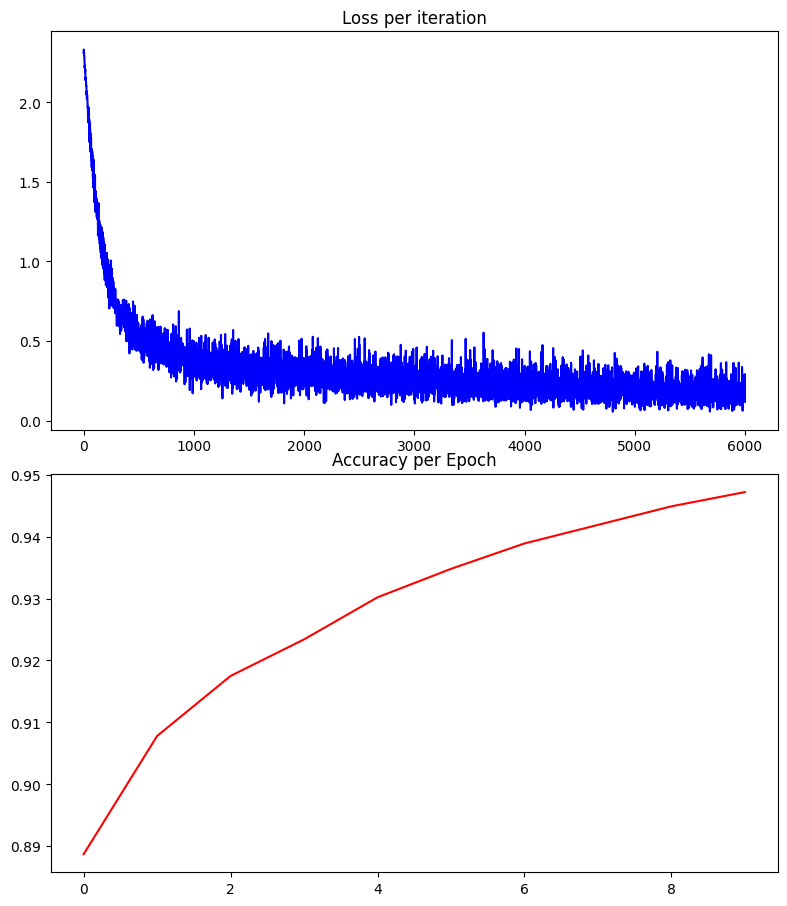

In [117]:
# plotting
y1, y2 = np.array(loss_values).flatten(), np.array(acc_values)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 9))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.title("Loss per iteration")
plt.plot(np.arange(y1.size), y1, label='Average Loss per iteration', color='blue')

plt.subplot(2, 1, 2)
plt.title("Accuracy per Epoch")
plt.plot(np.arange(y2.size), y2, label='Acc / Epoch', color='red')


plt.show()

#### Activation Function: $\sigma(x)$

In [118]:
# build an mlp
class Net_2(nn.Module):
    def __init__(self):
        super(Net_2, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 256)   # linear layer (784 -> 256)
        self.fc2 = nn.Linear(256,128)      # linear layer (256 -> 128)
        self.fc3 = nn.Linear(128,10)       # linear layer (128 -> 10)

    def forward(self, x):
        h0 = x.view(-1,28*28) #input layer
        h1 = F.sigmoid(self.fc1(h0)) # hidden layer 1
        h2 = F.sigmoid(self.fc2(h1)) # hidden layer 2
        h3 = self.fc3(h2) # output layer

        return h3

model = Net_2()
model.cuda() # put the model on GPU

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(),lr = args['lr'])

# data saves
loss_values, acc_values = [0]*args['epochs'], [0]*args['epochs']

# run model and grad
for epoch in range(1, args['epochs'] + 1):
    loss_values[epoch - 1] = train(epoch, model)
    acc_values[epoch - 1]  = test(model)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.332585
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.288367
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.311455
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.298960
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.287900
Train Epoch: 1 [5000/60000 (8%)]	Loss: 2.291364
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.301487
Train Epoch: 1 [7000/60000 (12%)]	Loss: 2.291524
Train Epoch: 1 [8000/60000 (13%)]	Loss: 2.284423
Train Epoch: 1 [9000/60000 (15%)]	Loss: 2.291404
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.282596
Train Epoch: 1 [11000/60000 (18%)]	Loss: 2.293198
Train Epoch: 1 [12000/60000 (20%)]	Loss: 2.294947
Train Epoch: 1 [13000/60000 (22%)]	Loss: 2.302465
Train Epoch: 1 [14000/60000 (23%)]	Loss: 2.288189
Train Epoch: 1 [15000/60000 (25%)]	Loss: 2.293398
Train Epoch: 1 [16000/60000 (27%)]	Loss: 2.276475
Train Epoch: 1 [17000/60000 (28%)]	Loss: 2.286551
Train Epoch: 1 [18000/60000 (30%)]	Loss: 2.288001
Train Epoch: 1 [19000/60000 (32%)]	Loss: 2.287100
Train Epoch: 1 [200

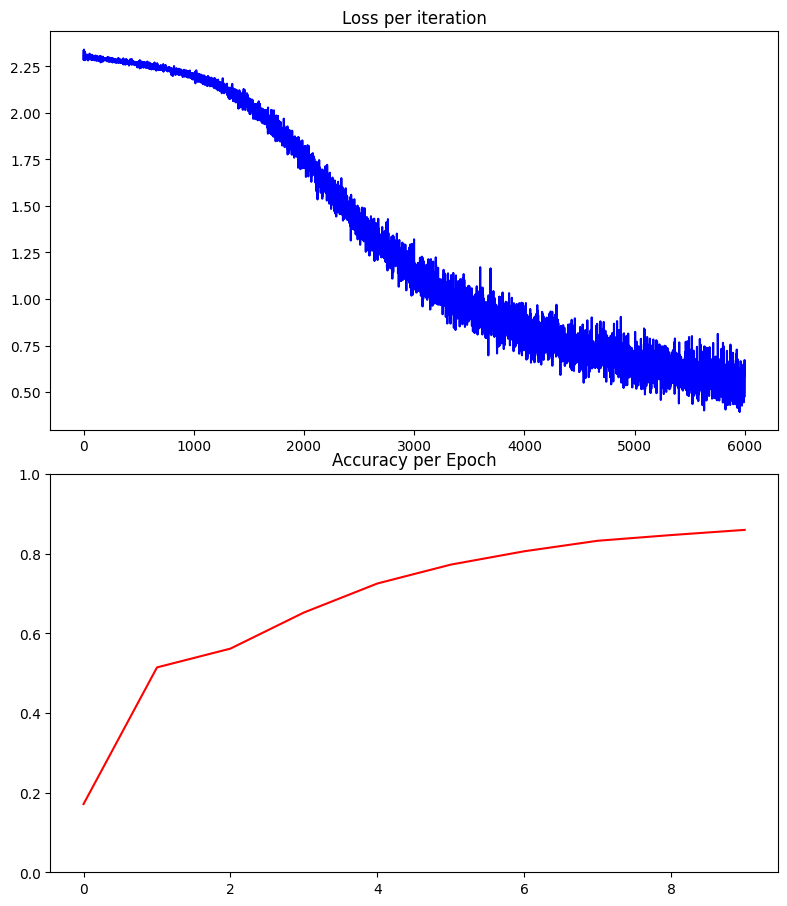

In [119]:
# plotting
y1, y2 = np.array(loss_values).flatten(), np.array(acc_values)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 9))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.title("Loss per iteration")
plt.plot(np.arange(y1.size), y1, label='Average Loss per iteration', color='blue')

plt.subplot(2, 1, 2)
plt.title("Accuracy per Epoch")
plt.plot(np.arange(y2.size), y2, label='Acc / Epoch', color='red')
plt.ylim([0, 1])


plt.show()

### 2. Please use different layers in the model, e.g., 1 layer, 5 layers, 10 layers,  and then plot the training loss and testing accuracy.

#### $4$ Layer Net 

In [120]:
# build an mlp
class Net_3(nn.Module):
    def __init__(self):
        super(Net_3, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 256)   # linear layer (784 -> 256)
        self.fc2 = nn.Linear(256,128)      # linear layer (256 -> 128)
        self.fc3 = nn.Linear(128,64)       # linear layer (128 -> 64)
        self.fc4 = nn.Linear(64,10)        # linear layer (64  -> 10)

    def forward(self, x):
        h0 = x.view(-1,28*28) #input layer
        h1 = F.leaky_relu(self.fc1(h0)) # hidden layer 1
        h2 = F.leaky_relu(self.fc2(h1)) # hidden layer 2
        h3 = F.relu(self.fc3(h2)) # hidden layer 3
        h4 = self.fc4(h3) # output layer

        return h4

model = Net_3()
model.cuda() # put the model on GPU

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(),lr = args['lr'])

# data saves
loss_values, acc_values = [0]*args['epochs'], [0]*args['epochs']

# run model and grad
for epoch in range(1, args['epochs'] + 1):
    loss_values[epoch - 1] = train(epoch, model)
    acc_values[epoch - 1]  = test(model)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.297835
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.293097
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.291254
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.300008
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.285312
Train Epoch: 1 [5000/60000 (8%)]	Loss: 2.277065
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.279197
Train Epoch: 1 [7000/60000 (12%)]	Loss: 2.271270
Train Epoch: 1 [8000/60000 (13%)]	Loss: 2.256688
Train Epoch: 1 [9000/60000 (15%)]	Loss: 2.247922
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.240697
Train Epoch: 1 [11000/60000 (18%)]	Loss: 2.238666
Train Epoch: 1 [12000/60000 (20%)]	Loss: 2.227944
Train Epoch: 1 [13000/60000 (22%)]	Loss: 2.201087
Train Epoch: 1 [14000/60000 (23%)]	Loss: 2.191791
Train Epoch: 1 [15000/60000 (25%)]	Loss: 2.190645
Train Epoch: 1 [16000/60000 (27%)]	Loss: 2.180243
Train Epoch: 1 [17000/60000 (28%)]	Loss: 2.132223
Train Epoch: 1 [18000/60000 (30%)]	Loss: 2.148651
Train Epoch: 1 [19000/60000 (32%)]	Loss: 2.115104
Train Epoch: 1 [200

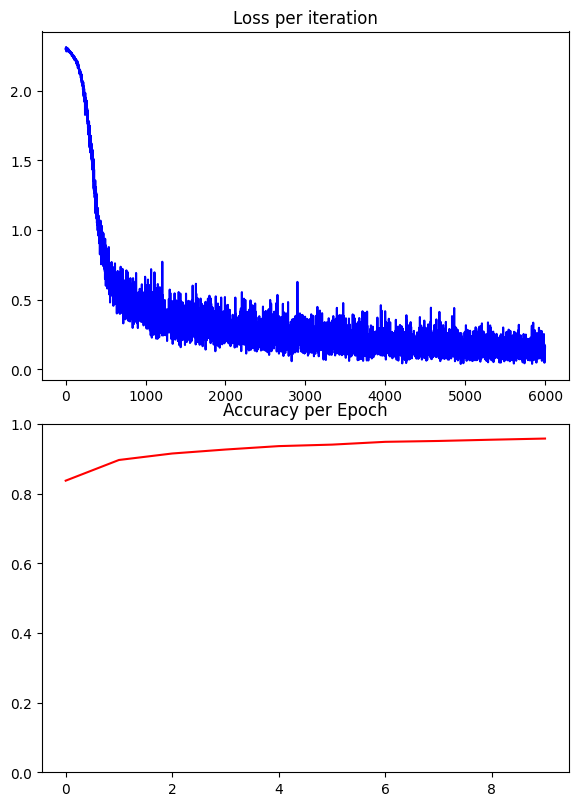

In [121]:
# plotting
y1, y2 = np.array(loss_values).flatten(), np.array(acc_values)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 8))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.title("Loss per iteration")
plt.plot(np.arange(y1.size), y1, label='Average Loss per iteration', color='blue')

plt.subplot(2, 1, 2)
plt.title("Accuracy per Epoch")
plt.plot(np.arange(y2.size), y2, label='Acc / Epoch', color='red')
plt.ylim([0, 1])

plt.show()

#### $8$ Layer Net

In [122]:
args['epochs'] = 20

class Net_8(nn.Module):
    def __init__(self):
        super(Net_8, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 512)   # linear layer (784 -> 512)
        self.fc2 = nn.Linear(512, 256)     # linear layer (512 -> 256)
        self.fc3 = nn.Linear(256, 128)     # linear layer (256 -> 128)
        self.fc4 = nn.Linear(128, 64)      # linear layer (128 -> 64)
        self.fc5 = nn.Linear(64, 64)       # linear layer (64 -> 64)
        self.fc6 = nn.Linear(64, 32)       # linear layer (64 -> 32)
        self.fc7 = nn.Linear(32, 16)       # linear layer (32 -> 16)
        self.fc8 = nn.Linear(16, 10)       # linear layer (16 -> 10)

    # mix of random functions
    def forward(self, x):
        h0 = x.view(-1,28*28)
        h1 = F.relu(self.fc1(h0))
        h2 = F.elu(self.fc2(h1))
        h3 = F.selu(self.fc3(h2))
        h4 = F.leaky_relu(self.fc4(h3), negative_slope=0.1)
        h5 = F.relu6(self.fc5(h4))
        h6 = F.relu(self.fc6(h5))
        h7 = F.hardswish(self.fc7(h6))
        h8 = self.fc8(h7)

        return h8


model = Net_8()
model.cuda() # put the model on GPU

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(),lr = args['lr'])

# data saves
loss_values, acc_values = [0]*args['epochs'], [0]*args['epochs']

# run model and grad
for epoch in range(1, args['epochs'] + 1):
    loss_values[epoch - 1] = train(epoch, model)
    acc_values[epoch - 1]  = test(model)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307387
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.294297
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.284816
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.298252
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.312324
Train Epoch: 1 [5000/60000 (8%)]	Loss: 2.310952
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.312002
Train Epoch: 1 [7000/60000 (12%)]	Loss: 2.307649
Train Epoch: 1 [8000/60000 (13%)]	Loss: 2.310778
Train Epoch: 1 [9000/60000 (15%)]	Loss: 2.305246
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.315093
Train Epoch: 1 [11000/60000 (18%)]	Loss: 2.290088
Train Epoch: 1 [12000/60000 (20%)]	Loss: 2.307380
Train Epoch: 1 [13000/60000 (22%)]	Loss: 2.308088
Train Epoch: 1 [14000/60000 (23%)]	Loss: 2.315935
Train Epoch: 1 [15000/60000 (25%)]	Loss: 2.308532
Train Epoch: 1 [16000/60000 (27%)]	Loss: 2.309974
Train Epoch: 1 [17000/60000 (28%)]	Loss: 2.302295
Train Epoch: 1 [18000/60000 (30%)]	Loss: 2.310009
Train Epoch: 1 [19000/60000 (32%)]	Loss: 2.313896
Train Epoch: 1 [200

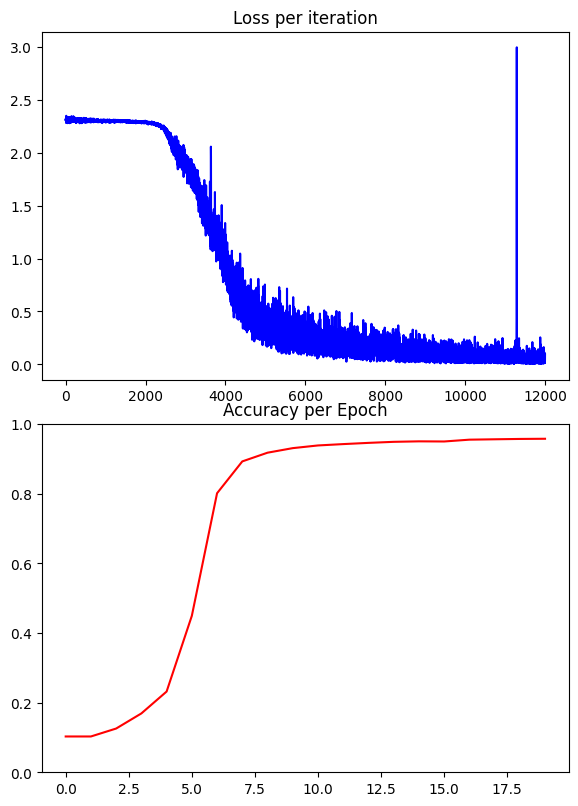

In [123]:
# plotting
y1, y2 = np.array(loss_values).flatten(), np.array(acc_values)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 8))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.title("Loss per iteration")
plt.plot(np.arange(y1.size), y1, label='Average Loss per iteration', color='blue')

plt.subplot(2, 1, 2)
plt.title("Accuracy per Epoch")
plt.plot(np.arange(y2.size), y2, label='Acc / Epoch', color='red')
plt.ylim([0, 1])

plt.show()